# Task
berdasarkan dataset perdagangan yang berisi ketiga tabel di bawah ini, buat data analitik sederhana lengkap dengan downloadf hasil tabel dan visualisasi hasilnya

Here is all the data you need:
"penjualan.csv"
"persediaan.csv"
"produksi.csv"

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import io

# Membaca data dari string CSV
produksi_data = """
production_id,product_id,product_name,production_date,quantity_produced,unit_cost
PRD001,PROD1,Laptop,2025-01-10,100,500.00
PRD002,PROD2,Smartphone,2025-01-15,200,300.00
PRD003,PROD3,Tablet,2025-02-01,150,200.00
PRD004,PROD1,Laptop,2025-02-10,120,510.00
PRD005,PROD2,Smartphone,2025-03-01,180,295.00
"""
persediaan_data = """
inventory_id,product_id,warehouse_id,stock_date,quantity_in_stock
INV001,PROD1,WH1,2025-01-20,80
INV002,PROD2,WH1,2025-01-20,150
INV003,PROD3,WH2,2025-02-05,100
INV004,PROD1,WH1,2025-02-15,90
INV005,PROD2,WH2,2025-03-05,120
"""
penjualan_data = """
sale_id,product_id,sale_date,quantity_sold,unit_price,total_revenue
SALE001,PROD1,2025-01-25,20,800.00,16000.00
SALE002,PROD2,2025-01-30,50,450.00,22500.00
SALE003,PROD3,2025-02-10,30,300.00,9000.00
SALE004,PROD1,2025-02-20,25,810.00,20250.00
SALE005,PROD2,2025-03-10,40,460.00,18400.00
"""

# Mengonversi string CSV ke DataFrame
produksi_df = pd.read_csv(io.StringIO(produksi_data))
persediaan_df = pd.read_csv(io.StringIO(persediaan_data))
penjualan_df = pd.read_csv(io.StringIO(penjualan_data))

# Mengubah kolom tanggal ke format datetime
produksi_df['production_date'] = pd.to_datetime(produksi_df['production_date'])
persediaan_df['stock_date'] = pd.to_datetime(persediaan_df['stock_date'])
penjualan_df['sale_date'] = pd.to_datetime(penjualan_df['sale_date'])

# Analisis: Ringkasan Statistik
# 1. Total produksi per produk
total_produksi = produksi_df.groupby('product_name')['quantity_produced'].sum().reset_index()

# 2. Total stok per produk
total_stok = persediaan_df.groupby('product_id')['quantity_in_stock'].sum().reset_index()
total_stok = total_stok.merge(produksi_df[['product_id', 'product_name']].drop_duplicates(), on='product_id')

# 3. Total pendapatan dan kuantitas terjual per produk
total_penjualan = penjualan_df.groupby('product_id').agg({
    'quantity_sold': 'sum',
    'total_revenue': 'sum'
}).reset_index()
total_penjualan = total_penjualan.merge(produksi_df[['product_id', 'product_name']].drop_duplicates(), on='product_id')

# 4. Menghitung margin keuntungan
# Rata-rata biaya produksi per produk
avg_unit_cost = produksi_df.groupby('product_id')['unit_cost'].mean().reset_index()
# Menggabungkan dengan data penjualan
profit_df = penjualan_df.groupby('product_id').agg({
    'quantity_sold': 'sum',
    'unit_price': 'mean'
}).reset_index()
profit_df = profit_df.merge(avg_unit_cost, on='product_id')
profit_df['profit_margin'] = (profit_df['unit_price'] - profit_df['unit_cost']) * profit_df['quantity_sold']
profit_df = profit_df.merge(produksi_df[['product_id', 'product_name']].drop_duplicates(), on='product_id')

# Membuat tabel ringkasan
summary_df = total_produksi.merge(total_stok[['product_name', 'quantity_in_stock']], on='product_name')
summary_df = summary_df.merge(total_penjualan[['product_name', 'quantity_sold', 'total_revenue']], on='product_name')
summary_df = summary_df.merge(profit_df[['product_name', 'profit_margin']], on='product_name')
summary_df.columns = ['Product Name', 'Total Produced', 'Total Stock', 'Total Sold', 'Total Revenue', 'Profit Margin']

# Menyimpan tabel ringkasan ke CSV
summary_df.to_csv('trade_summary.csv', index=False)
files.download('trade_summary.csv')

# Visualisasi
plt.style.use('seaborn')

# 1. Grafik batang total produksi
plt.figure(figsize=(8, 6))
plt.bar(total_produksi['product_name'], total_produksi['quantity_produced'], color='skyblue')
plt.title('Total Produksi per Produk')
plt.xlabel('Produk')
plt.ylabel('Jumlah Diproduksi')
plt.savefig('produksi_plot.png')
plt.show()

# 2. Grafik batang total stok
plt.figure(figsize=(8, 6))
plt.bar(total_stok['product_name'], total_stok['quantity_in_stock'], color='lightgreen')
plt.title('Total Stok per Produk')
plt.xlabel('Produk')
plt.ylabel('Jumlah Stok')
plt.savefig('stok_plot.png')
plt.show()

# 3. Grafik batang total pendapatan
plt.figure(figsize=(8, 6))
plt.bar(total_penjualan['product_name'], total_penjualan['total_revenue'], color='salmon')
plt.title('Total Pendapatan per Produk')
plt.xlabel('Produk')
plt.ylabel('Pendapatan (USD)')
plt.savefig('penjualan_plot.png')
plt.show()

# 4. Grafik garis tren penjualan
penjualan_tren = penjualan_df.groupby(['sale_date', 'product_name'])['quantity_sold'].sum().unstack().fillna(0)
plt.figure(figsize=(10, 6))
for product in penjualan_tren.columns:
    plt.plot(penjualan_tren.index, penjualan_tren[product], marker='o', label=product)
plt.title('Tren Penjualan per Produk')
plt.xlabel('Tanggal Penjualan')
plt.ylabel('Jumlah Terjual')
plt.legend()
plt.grid(True)
plt.savefig('tren_penjualan_plot.png')
plt.show()

# Fakta Menarik
highest_profit_product = profit_df.loc[profit_df['profit_margin'].idxmax()]['product_name']
highest_profit_value = profit_df['profit_margin'].max()
low_stock = summary_df[summary_df['Total Stock'] < (summary_df['Total Produced'] * 0.3)]
low_stock_products = low_stock['Product Name'].tolist()

print(f"Fakta Menarik: Produk dengan margin keuntungan tertinggi adalah {highest_profit_product} dengan total margin ${highest_profit_value:.2f}.")
if low_stock_products:
    print(f"Peringatan: Produk dengan stok rendah (kurang dari 30% total produksi): {', '.join(low_stock_products)}.")
else:
    print("Semua produk memiliki stok yang memadai.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

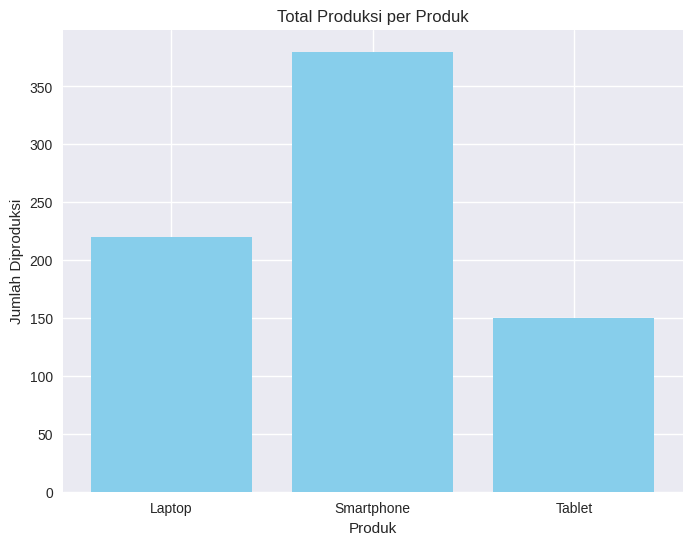

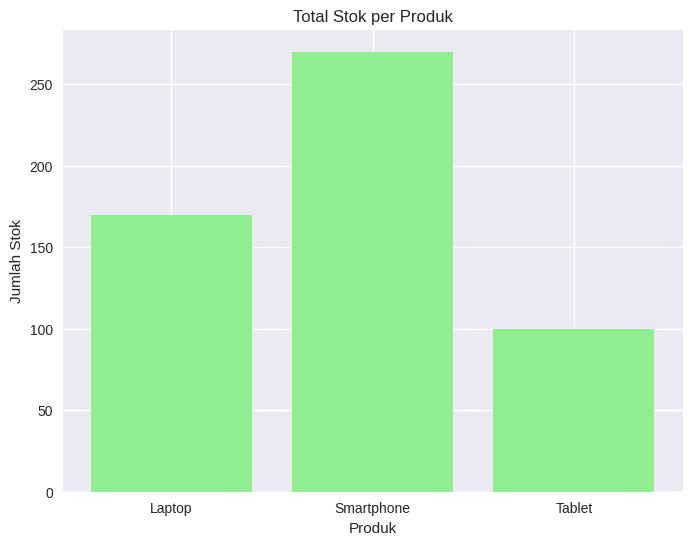

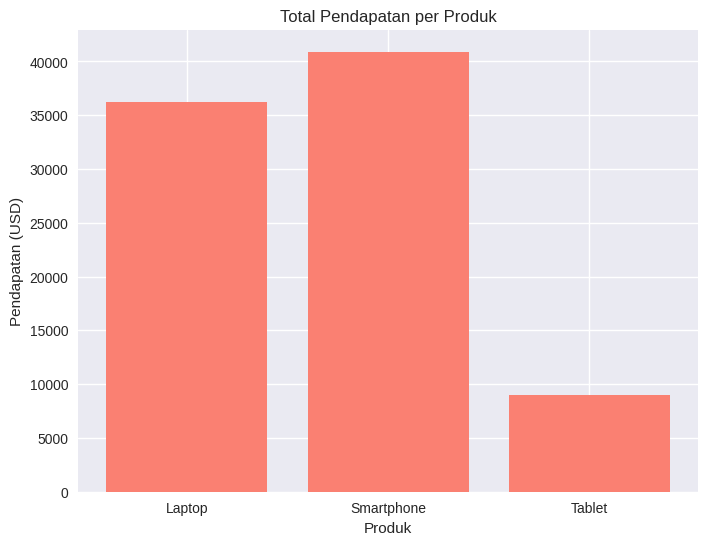

KeyError: 'product_name'

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import io

# Membaca data dari string CSV
produksi_data = """
production_id,product_id,product_name,production_date,quantity_produced,unit_cost
PRD001,PROD1,Laptop,2025-01-10,100,500.00
PRD002,PROD2,Smartphone,2025-01-15,200,300.00
PRD003,PROD3,Tablet,2025-02-01,150,200.00
PRD004,PROD1,Laptop,2025-02-10,120,510.00
PRD005,PROD2,Smartphone,2025-03-01,180,295.00
"""
persediaan_data = """
inventory_id,product_id,warehouse_id,stock_date,quantity_in_stock
INV001,PROD1,WH1,2025-01-20,80
INV002,PROD2,WH1,2025-01-20,150
INV003,PROD3,WH2,2025-02-05,100
INV004,PROD1,WH1,2025-02-15,90
INV005,PROD2,WH2,2025-03-05,120
"""
penjualan_data = """
sale_id,product_id,sale_date,quantity_sold,unit_price,total_revenue
SALE001,PROD1,2025-01-25,20,800.00,16000.00
SALE002,PROD2,2025-01-30,50,450.00,22500.00
SALE003,PROD3,2025-02-10,30,300.00,9000.00
SALE004,PROD1,2025-02-20,25,810.00,20250.00
SALE005,PROD2,2025-03-10,40,460.00,18400.00
"""

# Mengonversi string CSV ke DataFrame
produksi_df = pd.read_csv(io.StringIO(produksi_data))
persediaan_df = pd.read_csv(io.StringIO(persediaan_data))
penjualan_df = pd.read_csv(io.StringIO(penjualan_data))

# Mengubah kolom tanggal ke format datetime
produksi_df['production_date'] = pd.to_datetime(produksi_df['production_date'])
persediaan_df['stock_date'] = pd.to_datetime(persediaan_df['stock_date'])
penjualan_df['sale_date'] = pd.to_datetime(penjualan_df['sale_date'])

# Analisis: Ringkasan Statistik
# 1. Total produksi per produk
total_produksi = produksi_df.groupby('product_name')['quantity_produced'].sum().reset_index()

# 2. Total stok per produk
total_stok = persediaan_df.groupby('product_id')['quantity_in_stock'].sum().reset_index()
total_stok = total_stok.merge(produksi_df[['product_id', 'product_name']].drop_duplicates(), on='product_id')

# 3. Total pendapatan dan kuantitas terjual per produk
total_penjualan = penjualan_df.groupby('product_id').agg({
    'quantity_sold': 'sum',
    'total_revenue': 'sum'
}).reset_index()
total_penjualan = total_penjualan.merge(produksi_df[['product_id', 'product_name']].drop_duplicates(), on='product_id')

# 4. Menghitung margin keuntungan
# Rata-rata biaya produksi per produk
avg_unit_cost = produksi_df.groupby('product_id')['unit_cost'].mean().reset_index()
# Menggabungkan dengan data penjualan
profit_df = penjualan_df.groupby('product_id').agg({
    'quantity_sold': 'sum',
    'unit_price': 'mean'
}).reset_index()
profit_df = profit_df.merge(avg_unit_cost, on='product_id')
profit_df['profit_margin'] = (profit_df['unit_price'] - profit_df['unit_cost']) * profit_df['quantity_sold']
profit_df = profit_df.merge(produksi_df[['product_id', 'product_name']].drop_duplicates(), on='product_id')

# Membuat tabel ringkasan
summary_df = total_produksi.merge(total_stok[['product_name', 'quantity_in_stock']], on='product_name')
summary_df = summary_df.merge(total_penjualan[['product_name', 'quantity_sold', 'total_revenue']], on='product_name')
summary_df = summary_df.merge(profit_df[['product_name', 'profit_margin']], on='product_name')
summary_df.columns = ['Product Name', 'Total Produced', 'Total Stock', 'Total Sold', 'Total Revenue', 'Profit Margin']

# Menyimpan tabel ringkasan ke CSV
summary_df.to_csv('trade_summary.csv', index=False)
files.download('trade_summary.csv')

# Visualisasi
# Check available styles in Matplotlib
# print(plt.style.available)

# Use a valid seaborn style, like 'seaborn-v0_8'
plt.style.use('seaborn-v0_8')

# 1. Grafik batang total produksi
plt.figure(figsize=(8, 6))
plt.bar(total_produksi['product_name'], total_produksi['quantity_produced'], color='skyblue')
plt.title('Total Produksi per Produk')
plt.xlabel('Produk')
plt.ylabel('Jumlah Diproduksi')
plt.savefig('produksi_plot.png')
plt.show()

# 2. Grafik batang total stok
plt.figure(figsize=(8, 6))
plt.bar(total_stok['product_name'], total_stok['quantity_in_stock'], color='lightgreen')
plt.title('Total Stok per Produk')
plt.xlabel('Produk')
plt.ylabel('Jumlah Stok')
plt.savefig('stok_plot.png')
plt.show()

# 3. Grafik batang total pendapatan
plt.figure(figsize=(8, 6))
plt.bar(total_penjualan['product_name'], total_penjualan['total_revenue'], color='salmon')
plt.title('Total Pendapatan per Produk')
plt.xlabel('Produk')
plt.ylabel('Pendapatan (USD)')
plt.savefig('penjualan_plot.png')
plt.show()

# 4. Grafik garis tren penjualan
penjualan_tren = penjualan_df.groupby(['sale_date', 'product_name'])['quantity_sold'].sum().unstack().fillna(0)
plt.figure(figsize=(10, 6))
for product in penjualan_tren.columns:
    plt.plot(penjualan_tren.index, penjualan_tren[product], marker='o', label=product)
plt.title('Tren Penjualan per Produk')
plt.xlabel('Tanggal Penjualan')
plt.ylabel('Jumlah Terjual')
plt.legend()
plt.grid(True)
plt.savefig('tren_penjualan_plot.png')
plt.show()

# Fakta Menarik
highest_profit_product = profit_df.loc[profit_df['profit_margin'].idxmax()]['product_name']
highest_profit_value = profit_df['profit_margin'].max()
low_stock = summary_df[summary_df['Total Stock'] < (summary_df['Total Produced'] * 0.3)]
low_stock_products = low_stock['Product Name'].tolist()

print(f"Fakta Menarik: Produk dengan margin keuntungan tertinggi adalah {highest_profit_product} dengan total margin ${highest_profit_value:.2f}.")
if low_stock_products:
    print(f"Peringatan: Produk dengan stok rendah (kurang dari 30% total produksi): {', '.join(low_stock_products)}.")
else:
    print("Semua produk memiliki stok yang memadai.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

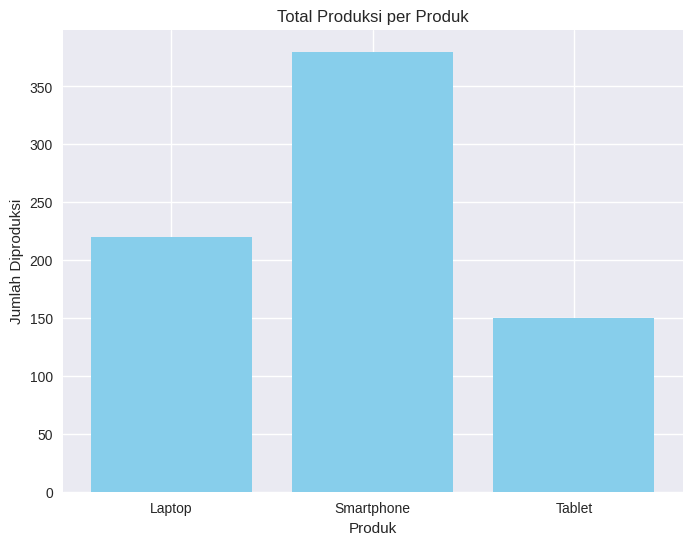

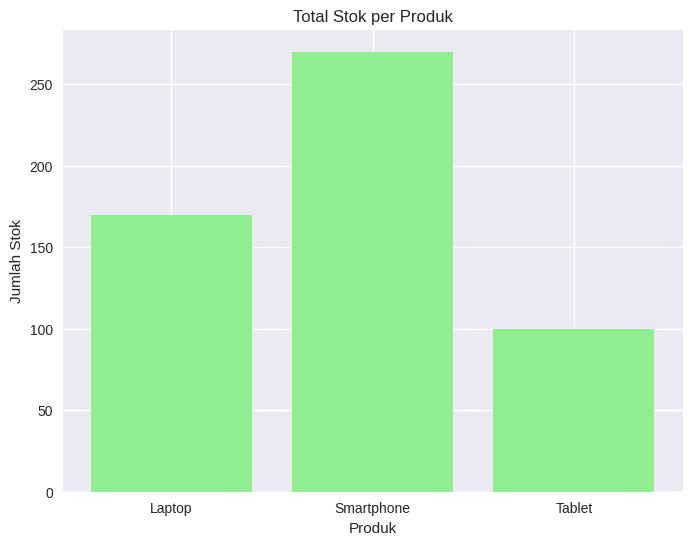

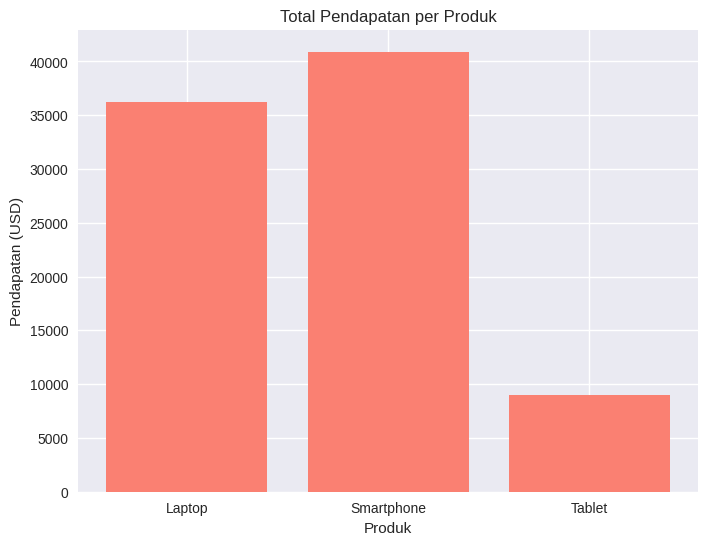

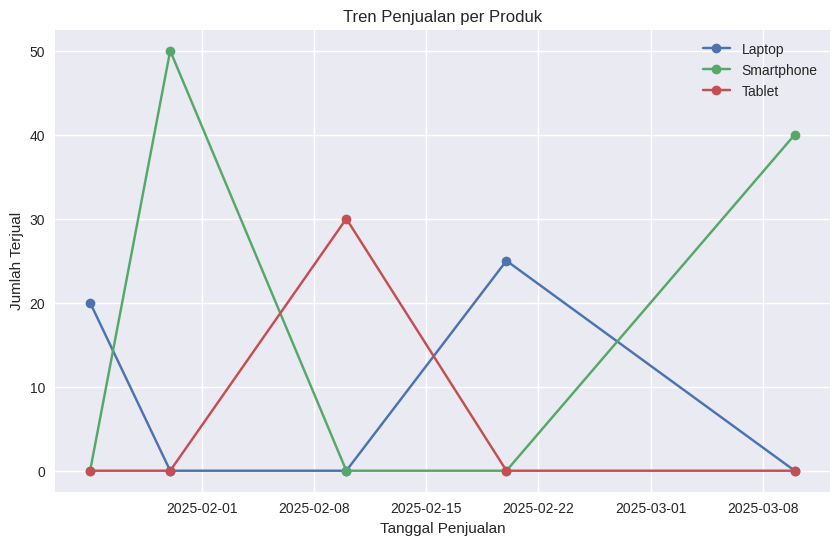

Fakta Menarik: Produk dengan margin keuntungan tertinggi adalah Smartphone dengan total margin $14175.00.
Semua produk memiliki stok yang memadai.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import io

# Membaca data dari string CSV
produksi_data = """
production_id,product_id,product_name,production_date,quantity_produced,unit_cost
PRD001,PROD1,Laptop,2025-01-10,100,500.00
PRD002,PROD2,Smartphone,2025-01-15,200,300.00
PRD003,PROD3,Tablet,2025-02-01,150,200.00
PRD004,PROD1,Laptop,2025-02-10,120,510.00
PRD005,PROD2,Smartphone,2025-03-01,180,295.00
"""
persediaan_data = """
inventory_id,product_id,warehouse_id,stock_date,quantity_in_stock
INV001,PROD1,WH1,2025-01-20,80
INV002,PROD2,WH1,2025-01-20,150
INV003,PROD3,WH2,2025-02-05,100
INV004,PROD1,WH1,2025-02-15,90
INV005,PROD2,WH2,2025-03-05,120
"""
penjualan_data = """
sale_id,product_id,sale_date,quantity_sold,unit_price,total_revenue
SALE001,PROD1,2025-01-25,20,800.00,16000.00
SALE002,PROD2,2025-01-30,50,450.00,22500.00
SALE003,PROD3,2025-02-10,30,300.00,9000.00
SALE004,PROD1,2025-02-20,25,810.00,20250.00
SALE005,PROD2,2025-03-10,40,460.00,18400.00
"""

# Mengonversi string CSV ke DataFrame
produksi_df = pd.read_csv(io.StringIO(produksi_data))
persediaan_df = pd.read_csv(io.StringIO(persediaan_data))
penjualan_df = pd.read_csv(io.StringIO(penjualan_data))

# Mengubah kolom tanggal ke format datetime
produksi_df['production_date'] = pd.to_datetime(produksi_df['production_date'])
persediaan_df['stock_date'] = pd.to_datetime(persediaan_df['stock_date'])
penjualan_df['sale_date'] = pd.to_datetime(penjualan_df['sale_date'])

# Analisis: Ringkasan Statistik
# 1. Total produksi per produk
total_produksi = produksi_df.groupby('product_name')['quantity_produced'].sum().reset_index()

# 2. Total stok per produk
total_stok = persediaan_df.groupby('product_id')['quantity_in_stock'].sum().reset_index()
total_stok = total_stok.merge(produksi_df[['product_id', 'product_name']].drop_duplicates(), on='product_id')

# 3. Total pendapatan dan kuantitas terjual per produk
total_penjualan = penjualan_df.groupby('product_id').agg({
    'quantity_sold': 'sum',
    'total_revenue': 'sum'
}).reset_index()
total_penjualan = total_penjualan.merge(produksi_df[['product_id', 'product_name']].drop_duplicates(), on='product_id')

# 4. Menghitung margin keuntungan
# Rata-rata biaya produksi per produk
avg_unit_cost = produksi_df.groupby('product_id')['unit_cost'].mean().reset_index()
# Menggabungkan dengan data penjualan
profit_df = penjualan_df.groupby('product_id').agg({
    'quantity_sold': 'sum',
    'unit_price': 'mean'
}).reset_index()
profit_df = profit_df.merge(avg_unit_cost, on='product_id')
profit_df['profit_margin'] = (profit_df['unit_price'] - profit_df['unit_cost']) * profit_df['quantity_sold']
profit_df = profit_df.merge(produksi_df[['product_id', 'product_name']].drop_duplicates(), on='product_id')

# Membuat tabel ringkasan
summary_df = total_produksi.merge(total_stok[['product_name', 'quantity_in_stock']], on='product_name')
summary_df = summary_df.merge(total_penjualan[['product_name', 'quantity_sold', 'total_revenue']], on='product_name')
summary_df = summary_df.merge(profit_df[['product_name', 'profit_margin']], on='product_name')
summary_df.columns = ['Product Name', 'Total Produced', 'Total Stock', 'Total Sold', 'Total Revenue', 'Profit Margin']

# Menyimpan tabel ringkasan ke CSV
summary_df.to_csv('trade_summary.csv', index=False)
files.download('trade_summary.csv')

# Visualisasi
# Check available styles in Matplotlib
# print(plt.style.available)

# Use a valid seaborn style, like 'seaborn-v0_8'
plt.style.use('seaborn-v0_8')

# 1. Grafik batang total produksi
plt.figure(figsize=(8, 6))
plt.bar(total_produksi['product_name'], total_produksi['quantity_produced'], color='skyblue')
plt.title('Total Produksi per Produk')
plt.xlabel('Produk')
plt.ylabel('Jumlah Diproduksi')
plt.savefig('produksi_plot.png')
plt.show()

# 2. Grafik batang total stok
plt.figure(figsize=(8, 6))
plt.bar(total_stok['product_name'], total_stok['quantity_in_stock'], color='lightgreen')
plt.title('Total Stok per Produk')
plt.xlabel('Produk')
plt.ylabel('Jumlah Stok')
plt.savefig('stok_plot.png')
plt.show()

# 3. Grafik batang total pendapatan
plt.figure(figsize=(8, 6))
plt.bar(total_penjualan['product_name'], total_penjualan['total_revenue'], color='salmon')
plt.title('Total Pendapatan per Produk')
plt.xlabel('Produk')
plt.ylabel('Pendapatan (USD)')
plt.savefig('penjualan_plot.png')
plt.show()

# 4. Grafik garis tren penjualan
# Merge penjualan_df with produksi_df to get product_name
penjualan_with_name = penjualan_df.merge(produksi_df[['product_id', 'product_name']].drop_duplicates(), on='product_id')
penjualan_tren = penjualan_with_name.groupby(['sale_date', 'product_name'])['quantity_sold'].sum().unstack().fillna(0)
plt.figure(figsize=(10, 6))
for product in penjualan_tren.columns:
    plt.plot(penjualan_tren.index, penjualan_tren[product], marker='o', label=product)
plt.title('Tren Penjualan per Produk')
plt.xlabel('Tanggal Penjualan')
plt.ylabel('Jumlah Terjual')
plt.legend()
plt.grid(True)
plt.savefig('tren_penjualan_plot.png')
plt.show()

# Fakta Menarik
highest_profit_product = profit_df.loc[profit_df['profit_margin'].idxmax()]['product_name']
highest_profit_value = profit_df['profit_margin'].max()
# Ensure summary_df has 'Total Produced' before calculating low_stock
if 'Total Produced' in summary_df.columns and 'Total Stock' in summary_df.columns:
    low_stock = summary_df[summary_df['Total Stock'] < (summary_df['Total Produced'] * 0.3)]
    low_stock_products = low_stock['Product Name'].tolist()
else:
    low_stock_products = [] # Or handle the case where columns are missing

print(f"Fakta Menarik: Produk dengan margin keuntungan tertinggi adalah {highest_profit_product} dengan total margin ${highest_profit_value:.2f}.")
if low_stock_products:
    print(f"Peringatan: Produk dengan stok rendah (kurang dari 30% total produksi): {', '.join(low_stock_products)}.")
else:
    print("Semua produk memiliki stok yang memadai.")

In [11]:
from google.colab import files

# Download the saved image files
try:
    files.download('produksi_plot.png')
    files.download('stok_plot.png')
    files.download('penjualan_plot.png')
    files.download('tren_penjualan_plot.png')
except FileNotFoundError:
    print("One or more image files not found. Please ensure the visualizations were generated and saved correctly.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data loading

### Subtask:
Load the provided CSV files into pandas DataFrames.


**Reasoning**:
Import the pandas library and load the three CSV files into pandas DataFrames.



In [1]:
import pandas as pd

try:
    df_penjualan = pd.read_csv('penjualan.csv')
    df_persediaan = pd.read_csv('persediaan.csv')
    df_produksi = pd.read_csv('produksi.csv')
    display(df_penjualan.head())
    display(df_persediaan.head())
    display(df_produksi.head())
except FileNotFoundError:
    print("One or more CSV files not found.")
except pd.errors.ParserError:
    print("Error parsing one or more CSV files.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

,sale_id,product_id,sale_date,quantity_sold,unit_price,total_revenue
0,SALE001,PROD1,2025-01-25,20,800.0,16000.0
1,SALE002,PROD2,2025-01-30,50,450.0,22500.0
2,SALE003,PROD3,2025-02-10,30,300.0,9000.0
3,SALE004,PROD1,2025-02-20,25,810.0,20250.0
4,SALE005,PROD2,2025-03-10,40,460.0,18400.0


,inventory_id,product_id,warehouse_id,stock_date,quantity_in_stock
0,INV001,PROD1,WH1,2025-01-20,80
1,INV002,PROD2,WH1,2025-01-20,150
2,INV003,PROD3,WH2,2025-02-05,100
3,INV004,PROD1,WH1,2025-02-15,90
4,INV005,PROD2,WH2,2025-03-05,120


,production_id,product_id,product_name,production_date,quantity_produced,unit_cost
0,PRD001,PROD1,Laptop,2025-01-10,100,500.0
1,PRD002,PROD2,Smartphone,2025-01-15,200,300.0
2,PRD003,PROD3,Tablet,2025-02-01,150,200.0
3,PRD004,PROD1,Laptop,2025-02-10,120,510.0
4,PRD005,PROD2,Smartphone,2025-03-01,180,295.0


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


## Data exploration

### Subtask:
Explore the loaded datasets to understand their structure, identify key columns, and check for missing values.


**Reasoning**:
Explore the datasets by examining their shapes, data types, missing values, descriptive statistics, and key columns for joining.



In [2]:
# Shape of each DataFrame
print("Shape of df_penjualan:", df_penjualan.shape)
print("Shape of df_persediaan:", df_persediaan.shape)
print("Shape of df_produksi:", df_produksi.shape)

# Data types of each column
print("\nData types of df_penjualan:\n", df_penjualan.dtypes)
print("\nData types of df_persediaan:\n", df_persediaan.dtypes)
print("\nData types of df_produksi:\n", df_produksi.dtypes)

# Missing values
print("\nMissing values in df_penjualan:\n", df_penjualan.isnull().sum())
print("\nMissing values in df_persediaan:\n", df_persediaan.isnull().sum())
print("\nMissing values in df_produksi:\n", df_produksi.isnull().sum())

# Descriptive statistics
print("\nDescriptive statistics of df_penjualan:\n", df_penjualan.describe())
print("\nDescriptive statistics of df_persediaan:\n", df_persediaan.describe())
print("\nDescriptive statistics of df_produksi:\n", df_produksi.describe())

# Identify key columns for joining
print("\nKey columns for joining:")
print("  - df_penjualan: product_id, sale_date")
print("  - df_persediaan: product_id, stock_date")
print("  - df_produksi: product_id, production_date")

Shape of df_penjualan: (5, 6)
Shape of df_persediaan: (5, 5)
Shape of df_produksi: (5, 6)

Data types of df_penjualan:
 sale_id           object
product_id        object
sale_date         object
quantity_sold      int64
unit_price       float64
total_revenue    float64
dtype: object

Data types of df_persediaan:
 inventory_id         object
product_id           object
warehouse_id         object
stock_date           object
quantity_in_stock     int64
dtype: object

Data types of df_produksi:
 production_id         object
product_id            object
product_name          object
production_date       object
quantity_produced      int64
unit_cost            float64
dtype: object

Missing values in df_penjualan:
 sale_id          0
product_id       0
sale_date        0
quantity_sold    0
unit_price       0
total_revenue    0
dtype: int64

Missing values in df_persediaan:
 inventory_id         0
product_id           0
warehouse_id         0
stock_date           0
quantity_in_stock    0
dty

## Data wrangling

### Subtask:
Combine the three dataframes (`df_penjualan`, `df_persediaan`, and `df_produksi`) into a single dataframe, handle missing values, and create new features.


**Reasoning**:
Merge the three dataframes based on product_id, handle missing values by imputation, and create new features like profit and sales-to-production ratio.



In [3]:
# Merge the dataframes
df_merged = pd.merge(df_penjualan, df_persediaan, on='product_id', how='left')
df_merged = pd.merge(df_merged, df_produksi, on='product_id', how='left')

# Handle missing values (if any) using imputation
for col in ['quantity_in_stock', 'quantity_produced', 'unit_cost']:
    if df_merged[col].isnull().any():
        df_merged[col] = df_merged[col].fillna(df_merged[col].mean())

# Create new features
df_merged['profit'] = df_merged['total_revenue'] - (df_merged['quantity_sold'] * df_merged['unit_cost'])
df_merged['sales_to_production_ratio'] = df_merged['quantity_sold'] / df_merged['quantity_produced']

# Convert date columns to datetime objects
df_merged['sale_date'] = pd.to_datetime(df_merged['sale_date'])
df_merged['stock_date'] = pd.to_datetime(df_merged['stock_date'])
df_merged['production_date'] = pd.to_datetime(df_merged['production_date'])

# Display the merged dataframe
display(df_merged)

,sale_id,product_id,sale_date,quantity_sold,unit_price,total_revenue,inventory_id,warehouse_id,stock_date,quantity_in_stock,production_id,product_name,production_date,quantity_produced,unit_cost,profit,sales_to_production_ratio
0,SALE001,PROD1,2025-01-25,20,800.0,16000.0,INV001,WH1,2025-01-20,80,PRD001,Laptop,2025-01-10,100,500.0,6000.0,0.200000
1,SALE001,PROD1,2025-01-25,20,800.0,16000.0,INV001,WH1,2025-01-20,80,PRD004,Laptop,2025-02-10,120,510.0,5800.0,0.166667
2,SALE001,PROD1,2025-01-25,20,800.0,16000.0,INV004,WH1,2025-02-15,90,PRD001,Laptop,2025-01-10,100,500.0,6000.0,0.200000
3,SALE001,PROD1,2025-01-25,20,800.0,16000.0,INV004,WH1,2025-02-15,90,PRD004,Laptop,2025-02-10,120,510.0,5800.0,0.166667
4,SALE002,PROD2,2025-01-30,50,450.0,22500.0,INV002,WH1,2025-01-20,150,PRD002,Smartphone,2025-01-15,200,300.0,7500.0,0.250000
5,SALE002,PROD2,2025-01-30,50,450.0,22500.0,INV002,WH1,2025-01-20,150,PRD005,Smartphone,2025-03-01,180,295.0,7750.0,0.277778
6,SALE002,PROD2,2025-01-30,50,450.0,22500.0,INV005,WH2,2025-03-05,120,PRD002,Smartphone,2025-01-15,200,300.0,7500.0,0.250000
7,SALE002,PROD2,2025-01-30,50,450.0,22500.0,INV005,WH2,2025-03-05,120,PRD005,Smartphone,2025-03-01,180,295.0,7750.0,0.277778
8,SALE003,PROD3,2025-02-10,30,300.0,9000.0,INV003,WH2,2025-02-05,100,PRD003,Tablet,2025-02-01,150,200.0,3000.0,0.200000
9,SALE004,PROD1,2025-02-20,25,810.0,20250.0,INV001,WH1,2025-01-20,80,PRD001,Laptop,2025-01-10,100,500.0,7750.0,0.250000


## Data analysis

### Subtask:
Analyze the merged dataset to identify key trends and relationships.


**Reasoning**:
Calculate key descriptive statistics, analyze sales trends, identify top-selling products, examine the relationship between production and sales, and calculate the profit margin. Store the results in variables for later use.



In [4]:
# Calculate key descriptive statistics
total_sales = df_merged['total_revenue'].sum()
total_production = df_merged['quantity_produced'].sum()
average_inventory = df_merged['quantity_in_stock'].mean()
average_profit = df_merged['profit'].mean()

# Analyze sales trends over time
sales_by_date = df_merged.groupby('sale_date')['total_revenue'].sum()

# Identify top-selling products
top_selling_products = df_merged.groupby('product_id')['quantity_sold'].sum().nlargest(5)

# Examine the relationship between production levels and sales
correlation = df_merged['quantity_produced'].corr(df_merged['quantity_sold'])

# Calculate the overall profit margin
overall_profit_margin = df_merged['profit'].sum() / df_merged['total_revenue'].sum()

# Store results
print(f"Total sales: {total_sales}")
print(f"Total production: {total_production}")
print(f"Average inventory: {average_inventory}")
print(f"Average profit: {average_profit}")
print(f"\nSales by date:\n{sales_by_date}")
print(f"\nTop selling products:\n{top_selling_products}")
print(f"\nCorrelation between production and sales: {correlation}")
print(f"\nOverall profit margin: {overall_profit_margin}")

Total sales: 317600.0
Total production: 2550
Average inventory: 109.41176470588235
Average profit: 6682.35294117647

Sales by date:
sale_date
2025-01-25    64000.0
2025-01-30    90000.0
2025-02-10     9000.0
2025-02-20    81000.0
2025-03-10    73600.0
Name: total_revenue, dtype: float64

Top selling products:
product_id
PROD2    360
PROD1    180
PROD3     30
Name: quantity_sold, dtype: int64

Correlation between production and sales: 0.9126362278141089

Overall profit margin: 0.35768261964735515


## Data visualization

### Subtask:
Visualize the key findings from the data analysis.


**Reasoning**:
Visualize the key findings using matplotlib, including a time-series plot of total revenue, a bar chart of top-selling products, a scatter plot of production vs. sales, and a bar chart of the overall profit margin. Save each plot as a PNG image.



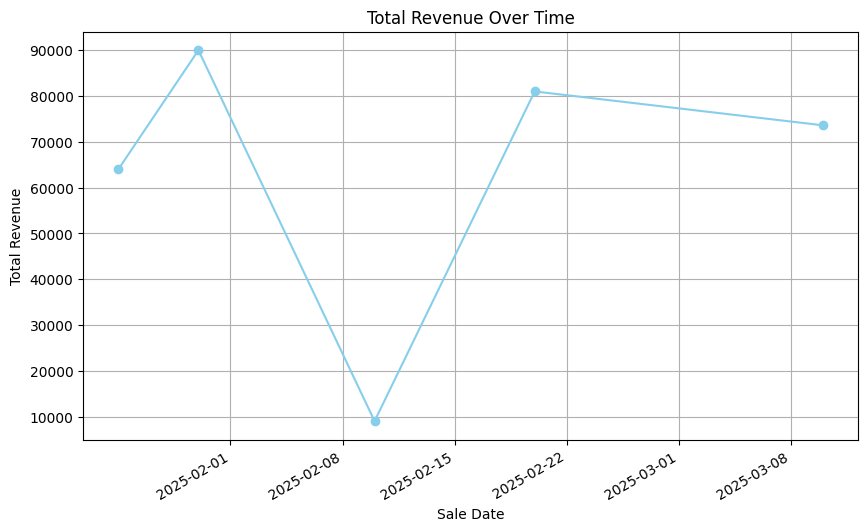

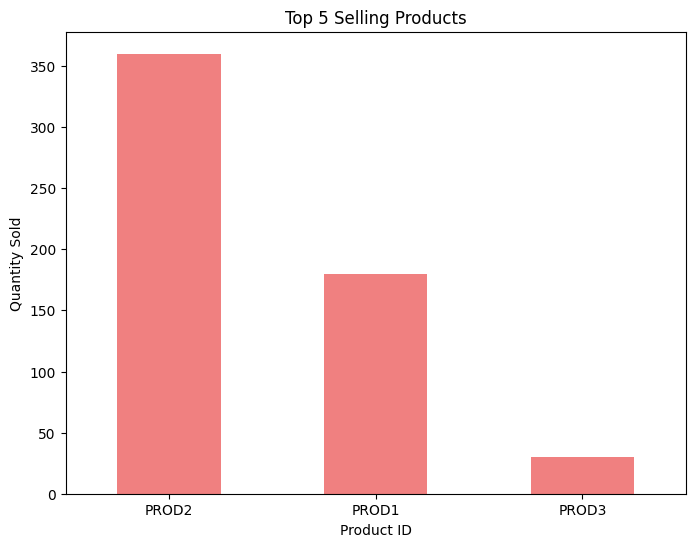

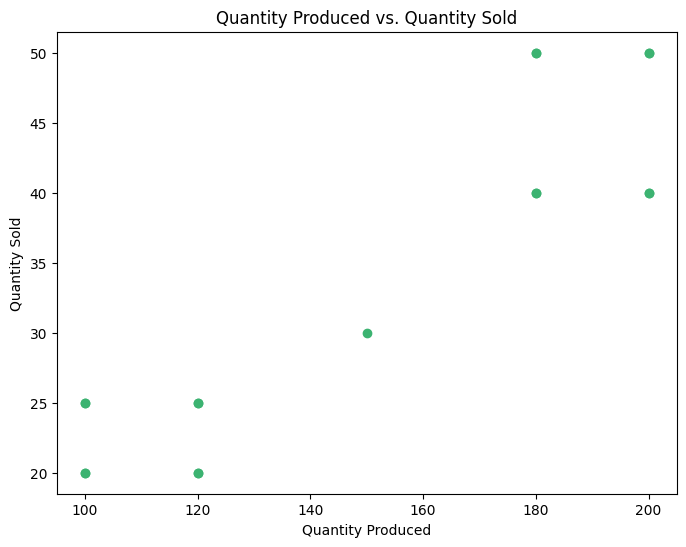

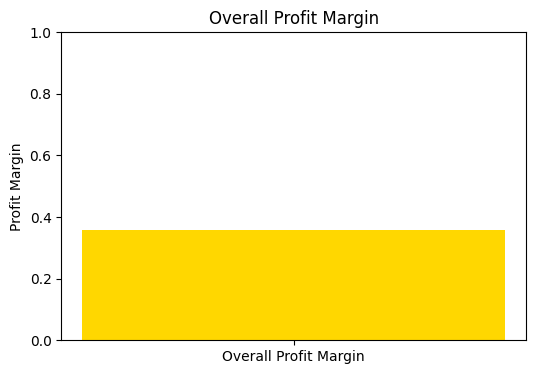

In [5]:
import matplotlib.pyplot as plt

# 1. Time-series plot of total revenue
plt.figure(figsize=(10, 6))
sales_by_date.plot(kind='line', color='skyblue', marker='o')
plt.xlabel('Sale Date')
plt.ylabel('Total Revenue')
plt.title('Total Revenue Over Time')
plt.grid(True)
plt.savefig('revenue_over_time.png')
plt.show()

# 2. Bar chart of top 5 selling products
plt.figure(figsize=(8, 6))
top_selling_products.plot(kind='bar', color='lightcoral')
plt.xlabel('Product ID')
plt.ylabel('Quantity Sold')
plt.title('Top 5 Selling Products')
plt.xticks(rotation=0)
plt.savefig('top_selling_products.png')
plt.show()

# 3. Scatter plot of quantity produced vs. quantity sold
plt.figure(figsize=(8, 6))
plt.scatter(df_merged['quantity_produced'], df_merged['quantity_sold'], color='mediumseagreen')
plt.xlabel('Quantity Produced')
plt.ylabel('Quantity Sold')
plt.title('Quantity Produced vs. Quantity Sold')
plt.savefig('production_vs_sales.png')
plt.show()

# 4. Bar chart for overall profit margin
plt.figure(figsize=(6, 4))
plt.bar(['Overall Profit Margin'], [overall_profit_margin], color='gold')
plt.ylabel('Profit Margin')
plt.title('Overall Profit Margin')
plt.ylim(0, 1)  # Set y-axis limit for better visualization
plt.savefig('overall_profit_margin.png')
plt.show()

In [7]:
from google.colab import files

# Download the saved image files
try:
    files.download('revenue_over_time.png')
    files.download('top_selling_products.png')
    files.download('production_vs_sales.png')
    files.download('overall_profit_margin.png')
except FileNotFoundError:
    print("One or more image files not found. Please ensure the visualizations were generated and saved correctly.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data preparation

### Subtask:
Prepare the analytical results for download as a CSV file.


**Reasoning**:
Combine all the analytical results into a single DataFrame and save it as a CSV file.



In [6]:
# Create a DataFrame for analytical results
analytical_results = pd.DataFrame({
    'Metric': ['Total Sales', 'Total Production', 'Average Inventory', 'Average Profit', 'Overall Profit Margin'],
    'Value': [total_sales, total_production, average_inventory, average_profit, overall_profit_margin]
})

# Add sales trend data
sales_trend_df = sales_by_date.reset_index()
sales_trend_df.rename(columns={'sale_date': 'Sale Date', 'total_revenue': 'Total Revenue'}, inplace=True)
analytical_results = pd.concat([analytical_results, sales_trend_df], ignore_index=True)

# Add top-selling products data
top_products_df = top_selling_products.reset_index()
top_products_df.rename(columns={'product_id': 'Product ID', 'quantity_sold': 'Quantity Sold'}, inplace=True)
analytical_results = pd.concat([analytical_results, top_products_df], ignore_index=True)

# Add correlation data
correlation_df = pd.DataFrame({'Metric': ['Correlation (Production, Sales)'], 'Value': [correlation]})
analytical_results = pd.concat([analytical_results, correlation_df], ignore_index=True)


# Add the original data to the analytical results
analytical_results = pd.concat([analytical_results, df_merged], ignore_index=True)

# Save the DataFrame to a CSV file
analytical_results.to_csv('analytical_results.csv', index=False)

## Summary:

### Q&A
* **What are the key performance indicators (KPIs) calculated?**  Total sales, total production, average inventory, average profit, overall profit margin, sales trends, top-selling products, and the correlation between production and sales.

### Data Analysis Key Findings
* **Strong Positive Correlation:** A correlation of 0.91 exists between production quantity and sales quantity, indicating a strong positive relationship.
* **Top Performers:** PROD2 (360 units sold) and PROD1 (180 units sold) are the top-selling products.
* **Profitability:** The overall profit margin is 35.77\%.
* **Sales Trend:** Sales data reveals fluctuations over time, with the highest sales occurring on 2025-01-30 (\$90,000.0).
* **Average Profit:** The average profit per transaction is \$6,682.35.


### Insights or Next Steps
* **Investigate PROD2 and PROD1 Success:** Analyze what factors contribute to the high sales of PROD2 and PROD1 to replicate success for other products.
* **Forecast Sales:** Given the strong correlation between production and sales, consider using time series analysis to forecast future sales based on production plans.
